# King County Housing Price Prediction

## Abstract

This notebook is analyzing the house data of king county using various regression and classification based models. Initial exploratory analysis helps us understand that only a select set of features are important and that other unwanted features don't contribute significantly for price prediction. By understanding the relation of numerical as well as categorical variables with the target variables, observing the correlation heat maps, handling missing data and outliers while performing data transformations we conclude the 7 most significant features for price prediction. 

In [1]:
# Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series
import os
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn import svm
from xgboost import XGBRegressor, XGBClassifier
from pprint import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# getting path of the data irrepective of which machine it is run from!
# current_dir = os.path.dirname(os.path.abspath(os.getcwd() + "/Random_Forest_Classifier.ipynb"))
# os.chdir('../data')
# data_dir = os.getcwd()
# data_dir = data_dir + '/king_county_cleansed.csv'
# data_dir

## Exploratory Data Analysis (EDA)

### 1. Understanding data and exploring the columns

In [3]:
data_dir = os.getcwd()
data_dir = data_dir + '/king_county_cleansed.csv'
house = pd.read_csv(data_dir)   # reading the csv data file

In [4]:
house.head(5)                   # observing the first 5 rows of data

index   price  bedrooms  bathrooms  sqft_living  sqft_lot  waterfront  \
0  16768  437500         3       2.25         1970     35100           0   
1   9596  790000         3       2.50         2600      4750           0   
2   9587  675000         5       2.50         2820     67518           0   
3  20602  555000         4       2.50         3310      6500           0   
4  11577  440000         4       2.25         2160      8119           0   

   sqft_above  sqft_basement  yr_built      ...       grade#10  grade#11  \
0        1970              0      1977      ...              0         0   
1        1700            900      1951      ...              0         0   
2        2820              0      1979      ...              0         0   
3        3310              0      2012      ...              0         0   
4        1080           1080      1966      ...              0         0   

   grade#12  grade#13  zipcode98004  zipcode98102  zipcode98109  zipcode98112  \
0         0         0             0             0             0             0   
1         0         0             0             0             0             0   
2         0         0             0             0             0             0   
3         0         0             0             0             0             0   
4         0         0             0             0             0             0   

   zipcode98039  zipcode98040  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0  

[5 rows x 51 columns]

In [5]:
house.shape   # given data has 21613 rows and 51 columns

(21613, 51)

In [6]:
house.columns      # looking at the colums to figure out what the data has to provide

Index(['index', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement_present',
       'renovated', 'floors#1.0', 'floors#1.5', 'floors#2.0', 'floors#2.5',
       'floors#3.0', 'floors#3.5', 'view0', 'view1', 'view2', 'view3', 'view4',
       'condition#1', 'condition#2', 'condition#3', 'condition#4',
       'condition#5', 'grade#1', 'grade#3', 'grade#4', 'grade#5', 'grade#6',
       'grade#7', 'grade#8', 'grade#9', 'grade#10', 'grade#11', 'grade#12',
       'grade#13', 'zipcode98004', 'zipcode98102', 'zipcode98109',
       'zipcode98112', 'zipcode98039', 'zipcode98040'],
      dtype='object')

In [7]:
# converting multi column view as well zipcode data into a single column data using encoding.

house.loc[house.view0 == 1, 'view'] = 1
house.loc[house.view1 == 1, 'view'] = 2
house.loc[house.view2 == 1, 'view'] = 3
house.loc[house.view3 == 1, 'view'] = 4
house.loc[house.view4 == 1, 'view'] = 5

house.loc[house.zipcode98004 == 1, 'zipcode'] = 1
house.loc[house.zipcode98102 == 1, 'zipcode'] = 2
house.loc[house.zipcode98109 == 1, 'zipcode'] = 3
house.loc[house.zipcode98112 == 1, 'zipcode'] = 4
house.loc[house.zipcode98039 == 1, 'zipcode'] = 5
house.loc[house.zipcode98040 == 1, 'zipcode'] = 6

From the above column names description we can make out that some of things are relevant when we go about purchasing a house. We generally look at the overall house first, i.e # of bathrooms, bedrooms, square footage of the area, how old is the house, is it recently renovated or just the same since a long time, where is it located geographically using the latitude and longitude information and lastly we end up seeing the price at which it is offered so as to get the best deal out of it. Obviously there are other variables too like # of floors, it's condition, the house grade and the view. While view does matter, we are transforming those multi column information into a single column of view. Likewise the zipcodes are encoded into a single column so as to contain the area specific information.

Considering that fact we take into consideration only important features like the ones discussed earlier. 

In [8]:
house = house[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'waterfront', 'basement_present', 'renovated', 'view', 'zipcode', 'price']]
house.head()

bedrooms  bathrooms  sqft_living  sqft_lot  sqft_living15  sqft_lot15  \
0         3       2.25         1970     35100           2340       35100   
1         3       2.50         2600      4750           2380        4750   
2         5       2.50         2820     67518           2820       48351   
3         4       2.50         3310      6500           2380        5000   
4         4       2.25         2160      8119           1850        9000   

   sqft_above  sqft_basement  yr_built  yr_renovated      lat     long  \
0        1970              0      1977             0  47.4635 -121.991   
1        1700            900      1951             0  47.6833 -122.400   
2        2820              0      1979             0  47.5794 -122.025   
3        3310              0      2012             0  47.5150 -121.870   
4        1080           1080      1966             0  47.5443 -122.177   

   waterfront  basement_present  renovated  view  zipcode   price  
0           0                 0          0   1.0      NaN  437500  
1           0                 1          0   1.0      NaN  790000  
2           0                 0          0   1.0      NaN  675000  
3           0                 0          0   1.0      NaN  555000  
4           0                 1          0   1.0      NaN  440000

In [9]:
house.describe()      # get the statistical scores from all the columns in the data provided

bedrooms     bathrooms   sqft_living      sqft_lot  sqft_living15  \
count  21613.000000  21613.000000  21613.000000  2.161300e+04   21613.000000   
mean       3.370842      2.114757   2079.899736  1.510697e+04    1986.552492   
std        0.930062      0.770163    918.440897  4.142051e+04     685.391304   
min        0.000000      0.000000    290.000000  5.200000e+02     399.000000   
25%        3.000000      1.750000   1427.000000  5.040000e+03    1490.000000   
50%        3.000000      2.250000   1910.000000  7.618000e+03    1840.000000   
75%        4.000000      2.500000   2550.000000  1.068800e+04    2360.000000   
max       33.000000      8.000000  13540.000000  1.651359e+06    6210.000000   

          sqft_lot15    sqft_above  sqft_basement      yr_built  yr_renovated  \
count   21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean    12768.455652   1788.390691     291.509045   1971.005136     84.402258   
std     27304.179631    828.090978     442.575043     29.373411    401.679240   
min       651.000000    290.000000       0.000000   1900.000000      0.000000   
25%      5100.000000   1190.000000       0.000000   1951.000000      0.000000   
50%      7620.000000   1560.000000       0.000000   1975.000000      0.000000   
75%     10083.000000   2210.000000     560.000000   1997.000000      0.000000   
max    871200.000000   9410.000000    4820.000000   2015.000000   2015.000000   

                lat          long    waterfront  basement_present  \
count  21613.000000  21613.000000  21613.000000      21613.000000   
mean      47.560053   -122.213896      0.007542          0.392680   
std        0.138564      0.140828      0.086517          0.488358   
min       47.155900   -122.519000      0.000000          0.000000   
25%       47.471000   -122.328000      0.000000          0.000000   
50%       47.571800   -122.230000      0.000000          0.000000   
75%       47.678000   -122.125000      0.000000          1.000000   
max       47.777600   -121.315000      1.000000          1.000000   

          renovated          view      zipcode         price  
count  21613.000000  21613.000000  1132.000000  2.161300e+04  
mean       0.042289      1.234303     3.420495  5.400881e+05  
std        0.201253      0.766318     1.922422  3.671272e+05  
min        0.000000      1.000000     1.000000  7.500000e+04  
25%        0.000000      1.000000     1.000000  3.219500e+05  
50%        0.000000      1.000000     4.000000  4.500000e+05  
75%        0.000000      1.000000     5.000000  6.450000e+05  
max        1.000000      5.000000     6.000000  7.700000e+06

In [10]:
house['price'].describe()   # shows descriptive information of the data provided

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

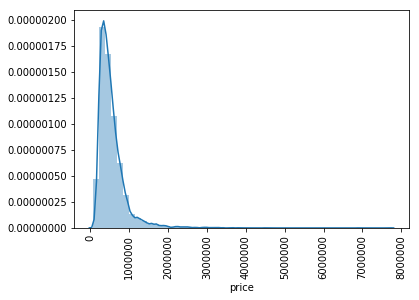

In [11]:
sns.distplot(house['price']);
plt.xticks(rotation=90);

From the above statistical analysis, we can observe that the minimum cost of the house given the data is USD 75,000 with the average price being USD 5,40,088 and the maximum being USD 77,00,000. It can be observed that the distribution of prices is right skewed, with a large concentration of prices belonging to the range less than USD 10,00,000.

In [12]:
house.shape  # we have reduced the data from 51 columns to a mere important 18 variable data

(21613, 18)

In [13]:
house.dtypes  # we observe that the columns are mostly numerical data either integer or categorical

bedrooms              int64
bathrooms           float64
sqft_living           int64
sqft_lot              int64
sqft_living15         int64
sqft_lot15            int64
sqft_above            int64
sqft_basement         int64
yr_built              int64
yr_renovated          int64
lat                 float64
long                float64
waterfront            int64
basement_present      int64
renovated             int64
view                float64
zipcode             float64
price                 int64
dtype: object

In [14]:
house.describe(include='all')             

bedrooms     bathrooms   sqft_living      sqft_lot  sqft_living15  \
count  21613.000000  21613.000000  21613.000000  2.161300e+04   21613.000000   
mean       3.370842      2.114757   2079.899736  1.510697e+04    1986.552492   
std        0.930062      0.770163    918.440897  4.142051e+04     685.391304   
min        0.000000      0.000000    290.000000  5.200000e+02     399.000000   
25%        3.000000      1.750000   1427.000000  5.040000e+03    1490.000000   
50%        3.000000      2.250000   1910.000000  7.618000e+03    1840.000000   
75%        4.000000      2.500000   2550.000000  1.068800e+04    2360.000000   
max       33.000000      8.000000  13540.000000  1.651359e+06    6210.000000   

          sqft_lot15    sqft_above  sqft_basement      yr_built  yr_renovated  \
count   21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean    12768.455652   1788.390691     291.509045   1971.005136     84.402258   
std     27304.179631    828.090978     442.575043     29.373411    401.679240   
min       651.000000    290.000000       0.000000   1900.000000      0.000000   
25%      5100.000000   1190.000000       0.000000   1951.000000      0.000000   
50%      7620.000000   1560.000000       0.000000   1975.000000      0.000000   
75%     10083.000000   2210.000000     560.000000   1997.000000      0.000000   
max    871200.000000   9410.000000    4820.000000   2015.000000   2015.000000   

                lat          long    waterfront  basement_present  \
count  21613.000000  21613.000000  21613.000000      21613.000000   
mean      47.560053   -122.213896      0.007542          0.392680   
std        0.138564      0.140828      0.086517          0.488358   
min       47.155900   -122.519000      0.000000          0.000000   
25%       47.471000   -122.328000      0.000000          0.000000   
50%       47.571800   -122.230000      0.000000          0.000000   
75%       47.678000   -122.125000      0.000000          1.000000   
max       47.777600   -121.315000      1.000000          1.000000   

          renovated          view      zipcode         price  
count  21613.000000  21613.000000  1132.000000  2.161300e+04  
mean       0.042289      1.234303     3.420495  5.400881e+05  
std        0.201253      0.766318     1.922422  3.671272e+05  
min        0.000000      1.000000     1.000000  7.500000e+04  
25%        0.000000      1.000000     1.000000  3.219500e+05  
50%        0.000000      1.000000     4.000000  4.500000e+05  
75%        0.000000      1.000000     5.000000  6.450000e+05  
max        1.000000      5.000000     6.000000  7.700000e+06

Above table will help you describe all columns of dataframe and give their statistical significance. This includes information not only of the numerical variables but also the categorical variables.

In [15]:
house.isna().sum()

bedrooms                0
bathrooms               0
sqft_living             0
sqft_lot                0
sqft_living15           0
sqft_lot15              0
sqft_above              0
sqft_basement           0
yr_built                0
yr_renovated            0
lat                     0
long                    0
waterfront              0
basement_present        0
renovated               0
view                    0
zipcode             20481
price                   0
dtype: int64

From the above code, we can observe that there are no NA terms in the columns or the variables provided except for the zipcode column. So of the 21613 rows of data given about 20481 rows of data are NaN values for zipcode. Although zipcode would have acted as a good feature for understanding housing prices in certain areas, the given data won't help much and dropping this column will make sense.

In [16]:
house.pop('zipcode')
house.head()

bedrooms  bathrooms  sqft_living  sqft_lot  sqft_living15  sqft_lot15  \
0         3       2.25         1970     35100           2340       35100   
1         3       2.50         2600      4750           2380        4750   
2         5       2.50         2820     67518           2820       48351   
3         4       2.50         3310      6500           2380        5000   
4         4       2.25         2160      8119           1850        9000   

   sqft_above  sqft_basement  yr_built  yr_renovated      lat     long  \
0        1970              0      1977             0  47.4635 -121.991   
1        1700            900      1951             0  47.6833 -122.400   
2        2820              0      1979             0  47.5794 -122.025   
3        3310              0      2012             0  47.5150 -121.870   
4        1080           1080      1966             0  47.5443 -122.177   

   waterfront  basement_present  renovated  view   price  
0           0                 0          0   1.0  437500  
1           0                 1          0   1.0  790000  
2           0                 0          0   1.0  675000  
3           0                 0          0   1.0  555000  
4           0                 1          0   1.0  440000

In [17]:
house['yr_renovated'].unique()  # just trying to observe how many unique year elements are there. This seems to be quite exhaustive

array([   0, 1994, 1958, 1954, 2011, 2014, 1992, 1998, 2013, 2002, 2004,
       2005, 1986, 1990, 2001, 1984, 1956, 2010, 2000, 2003, 1977, 1996,
       2007, 1981, 1970, 1983, 1975, 1971, 1988, 1999, 2009, 1995, 1997,
       1969, 2015, 1982, 1989, 2006, 1993, 1985, 1953, 1955, 1979, 1987,
       1960, 1934, 1945, 2008, 1980, 2012, 1972, 1948, 1978, 1968, 1991,
       1974, 1965, 1946, 1940, 1963, 1976, 1964, 1973, 1967, 1944, 1959,
       1957, 1962, 1951, 1950])

In [18]:
house.astype(bool).sum(axis=0)

bedrooms            21600
bathrooms           21603
sqft_living         21613
sqft_lot            21613
sqft_living15       21613
sqft_lot15          21613
sqft_above          21613
sqft_basement        8487
yr_built            21613
yr_renovated          914
lat                 21613
long                21613
waterfront            163
basement_present     8487
renovated             914
view                21613
price               21613
dtype: int64

The above data shows the amount of non-zero values present in each data column. This helps in understanding which columns won't convey any significant amount of information and helps us in dropping them. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72527dccf8>,
      dtype=object)

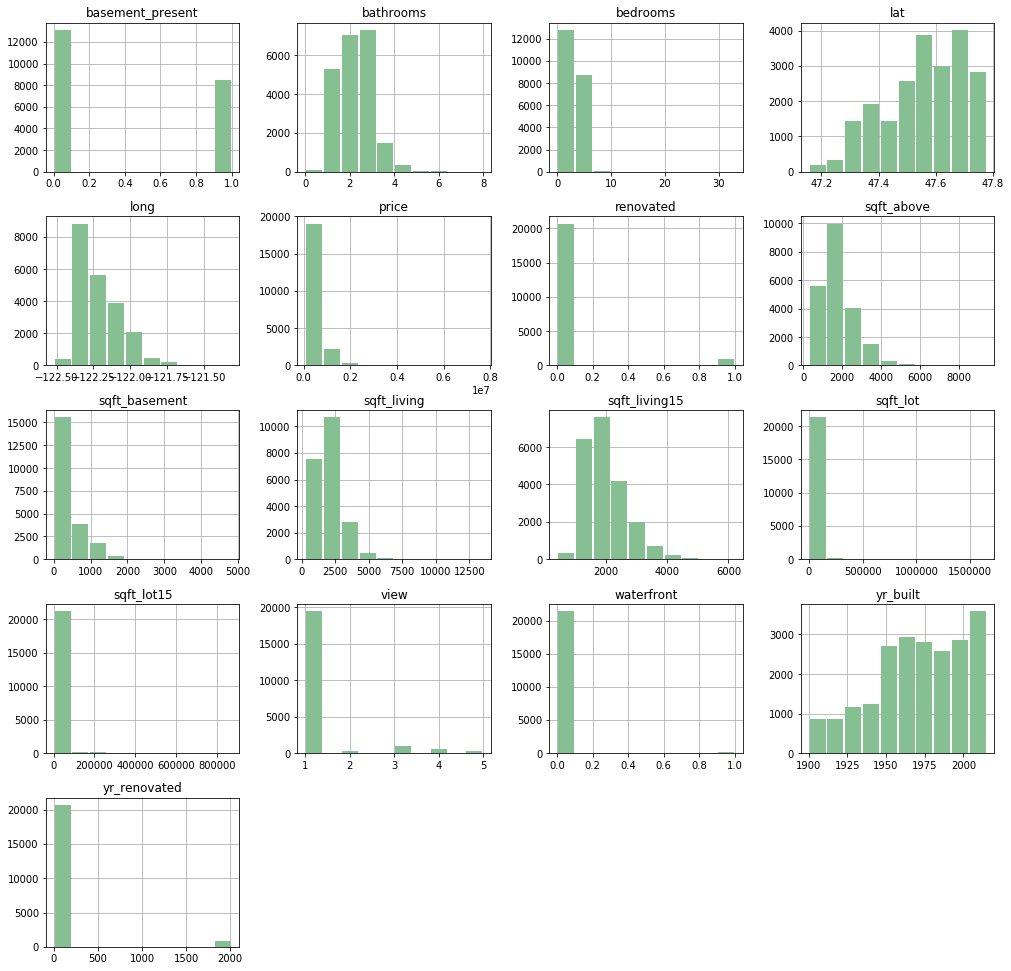

In [19]:
# plot histogram to get frequency count of each variable. 

house.hist(figsize=(17,17), color='#86bf91', zorder=2, rwidth=0.9) 

From the above exploratory analysis we observe the following from the histograms provided:

1. We observe that houses generally have bathrooms in the range 1-4. 
2. We observe that usually a house has 2-5 bedrooms max depending upon the house size. 
3. We observe that for houses with sq_ft_above in the 100-4000 range are really high.
4. We observe that for houses with sq_ft_living in the  100-3000 range is highly present.
5. Lastly, we see that an appreciable amount of houses are built after the 1960's with highest bars available after the 2000's

In [20]:
house.info()   # gives detailed information of each column as to whether they contain null values or not

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
bedrooms            21613 non-null int64
bathrooms           21613 non-null float64
sqft_living         21613 non-null int64
sqft_lot            21613 non-null int64
sqft_living15       21613 non-null int64
sqft_lot15          21613 non-null int64
sqft_above          21613 non-null int64
sqft_basement       21613 non-null int64
yr_built            21613 non-null int64
yr_renovated        21613 non-null int64
lat                 21613 non-null float64
long                21613 non-null float64
waterfront          21613 non-null int64
basement_present    21613 non-null int64
renovated           21613 non-null int64
view                21613 non-null float64
price               21613 non-null int64
dtypes: float64(4), int64(13)
memory usage: 2.8 MB


### 2. Relationship of target variable with Numerical Variables - Scatter Plots

We will now try to figure out the relationship between continuous value variables and target variable to see how it behaves and what kind of trend we observe.

We start off with observing the trend of bedrooms vs the house price.

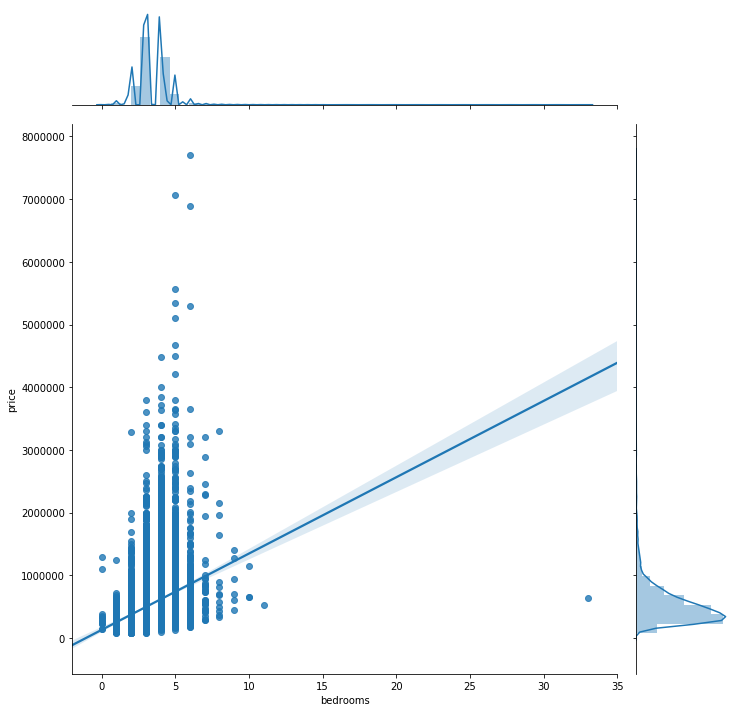

In [21]:
sns.jointplot(x="bedrooms", y="price", data=house, kind = 'reg', height = 10)
plt.show()

Bedrooms are not linearly co-related with price since it is showing non-normal distribution pattern. It is not showing peak behaviour multiple times.

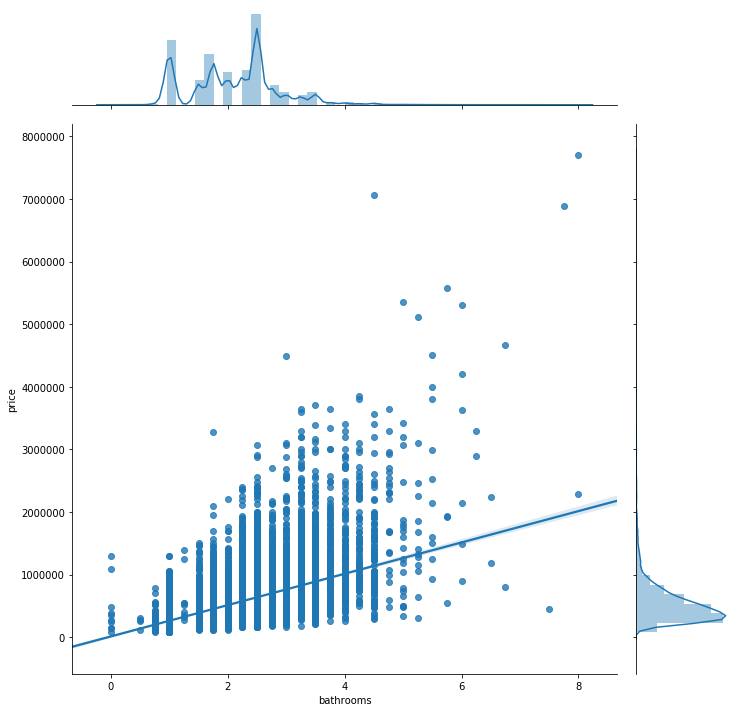

In [22]:
sns.jointplot(x="bathrooms", y="price", data=house, kind = 'reg', height = 10)
plt.show()

Bathrooms show a linear trend but the data is not concentrated and is kind of ditributed on the higher side as the number of bathrooms increase. Also there are significant number of outliers and the distribution has multiple peaks.

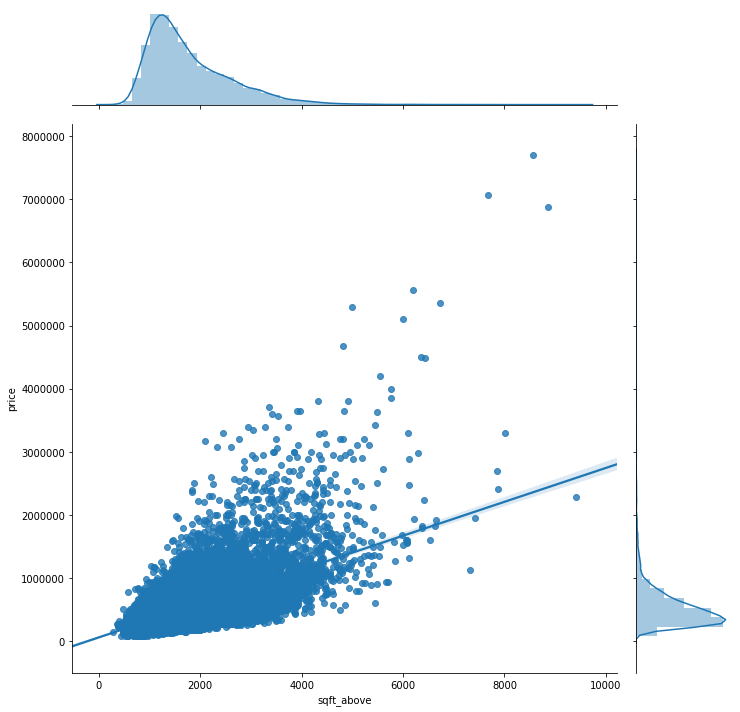

In [23]:
sns.jointplot(x="sqft_above", y="price", data=house, kind = 'reg', height = 10)
plt.show()

The above plot shows nature of above sq ft area of house wrt to price. As we can see, the data is linear in nature and that it has dense population. The distribution is left skewed and it too contains significant amount of outliers on the higher side

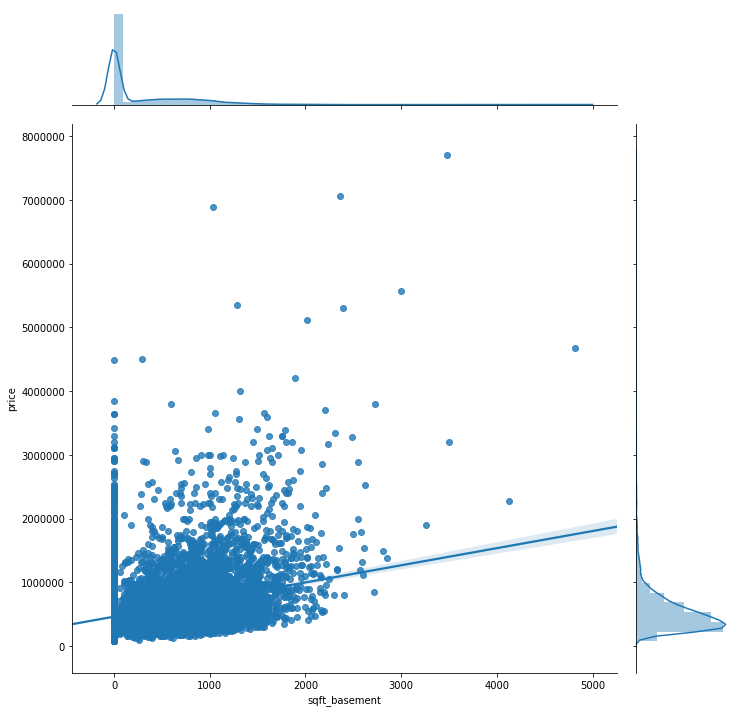

In [24]:
sns.jointplot(x="sqft_basement", y="price", data=house, kind = 'reg', height = 10)
plt.show()

Above plot shows that for houses having no basement at all, the distribution is showing a line on the left. Else it shows a linear nature and a cloud of points. There are many many outliers and they lie well above the linear seperation line. There is left skewness in the distribution plot and 

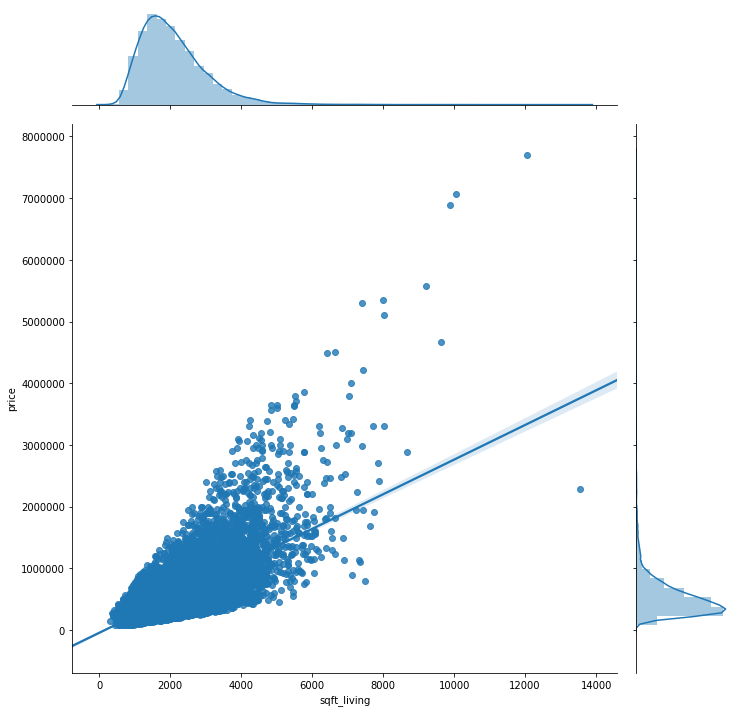

In [25]:
sns.jointplot(x="sqft_living", y="price", data=house, kind = 'reg', height = 10)
plt.show()

The above plot shows that living area sq ft is growing linearly and has a steep slope. Also its distribution is left skewed and has a couple of off-linear points.

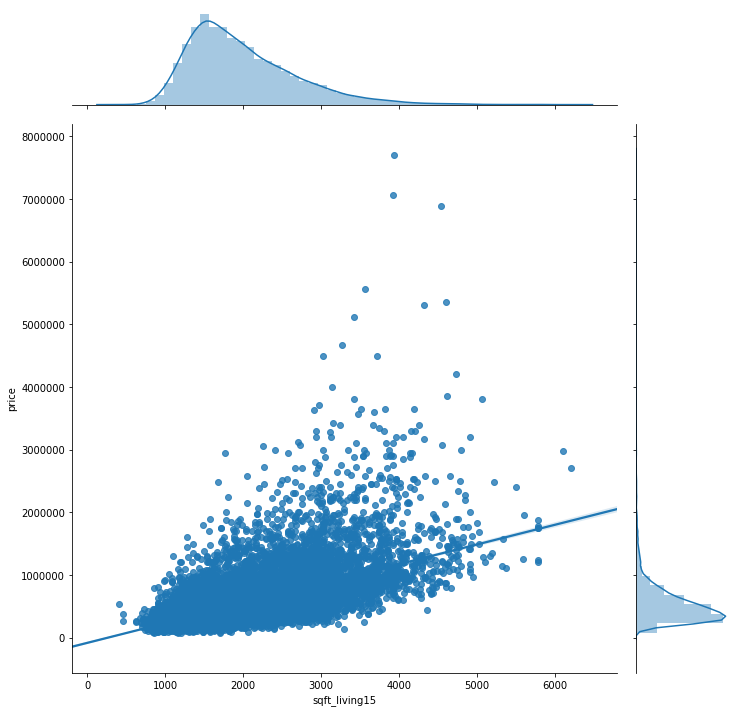

In [26]:
sns.jointplot(x="sqft_living15", y="price", data=house, kind = 'reg', height = 10)
plt.show()

The above distribution is also quite dense and is linear. significant outliers lie well above the linear line.The distribution is almost normal with slight flavour of skewness on the left.

The below 5 distributions are not particularly linear. We can just observe how sparse the data spread is seeing these variables wrt to the price variable. We then try to understand if it is relevant to keep these features by performing many other analysis

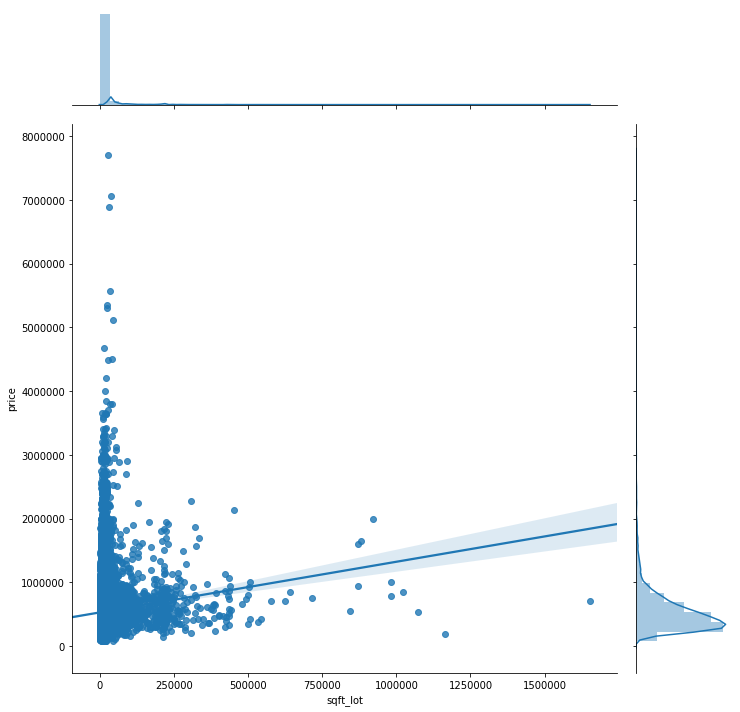

In [27]:
sns.jointplot(x="sqft_lot", y="price", data=house, kind = 'reg', height = 10)
plt.show()

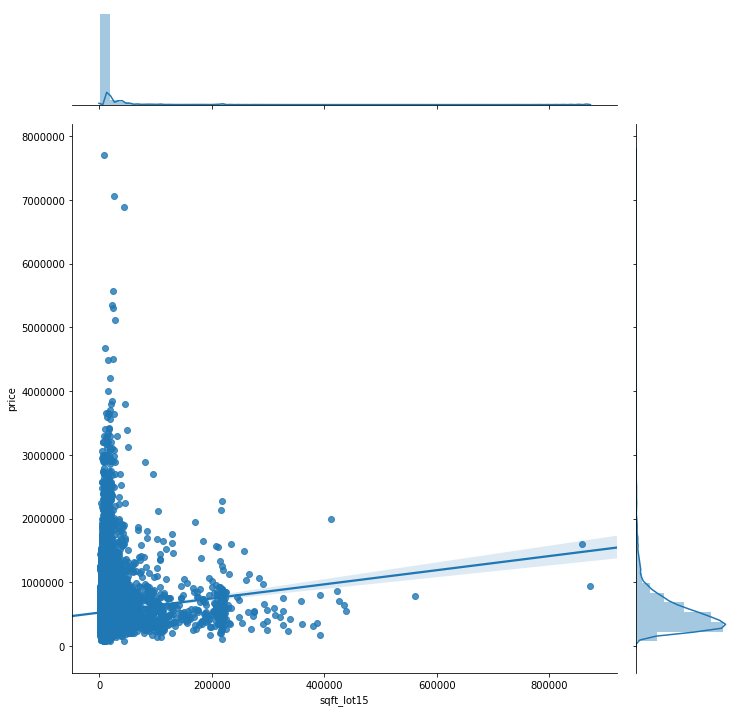

In [28]:
sns.jointplot(x="sqft_lot15", y="price", data=house, kind = 'reg', height = 10)
plt.show()

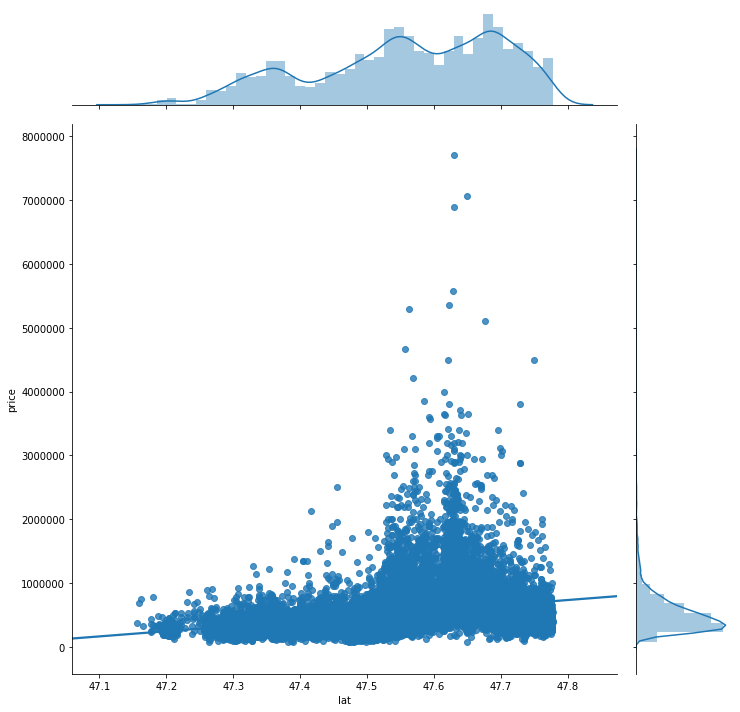

In [29]:
sns.jointplot(x="lat", y="price", data=house, kind = 'reg', height = 10)
plt.show()

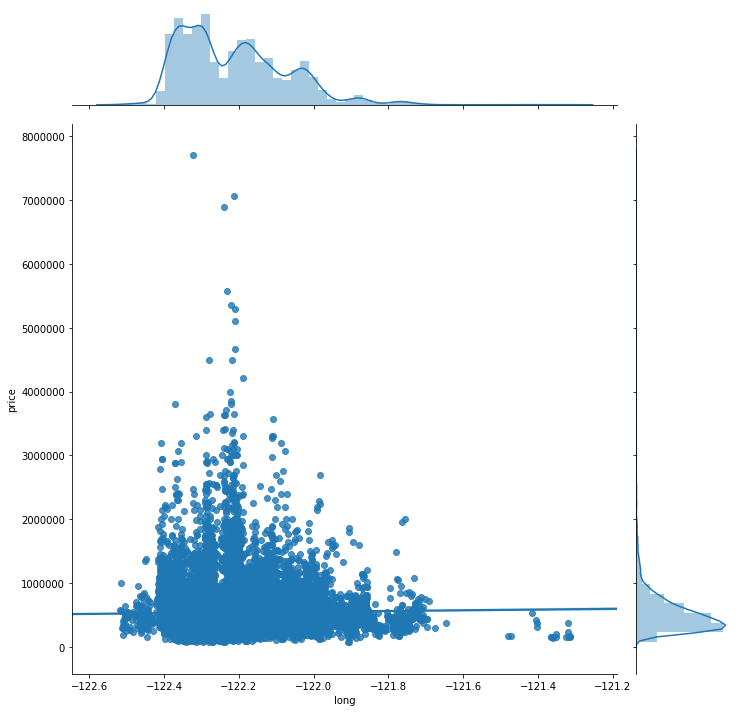

In [30]:
sns.jointplot(x="long", y="price", data=house, kind = 'reg', height = 10)
plt.show()

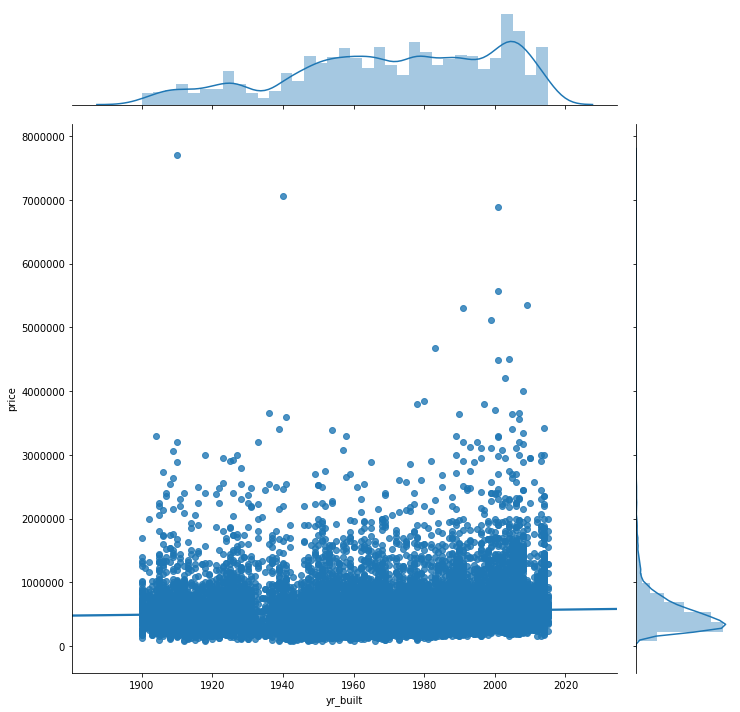

In [31]:
sns.jointplot(x="yr_built", y="price", data=house, kind = 'reg', height = 10)
plt.show()

### 3. Relationship of target variable with Categorical Variables - Box Plots

We will now try to find relationship between categorical variables and target variables. If there is significant relation then we will try to use those predictor variables.

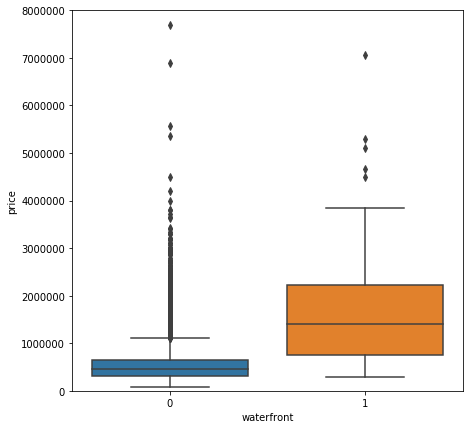

In [32]:
var = 'waterfront'
data = pd.concat([house['price'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(7, 7))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

The above box plot shows that the variable waterfront has majority 1 values and relatively less 0 values indicating that houses in the data has waterfront present in most of them. 

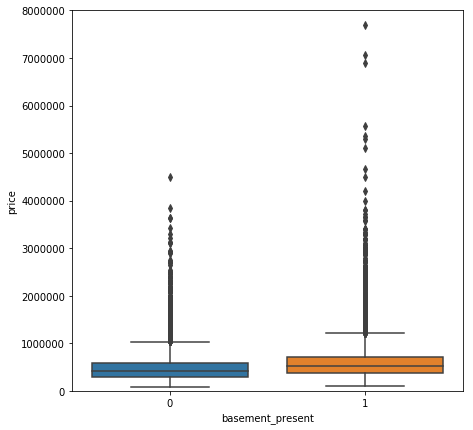

In [33]:
var = 'basement_present'
data = pd.concat([house['price'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(7, 7))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

For basement present less data lie in the interquartile range and it has many outliers

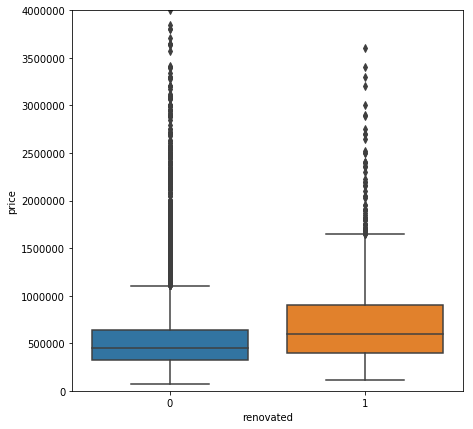

In [34]:
var = 'renovated'
data = pd.concat([house['price'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(7, 7))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=4000000);

For the variable named renovated, too the outliers are quite high

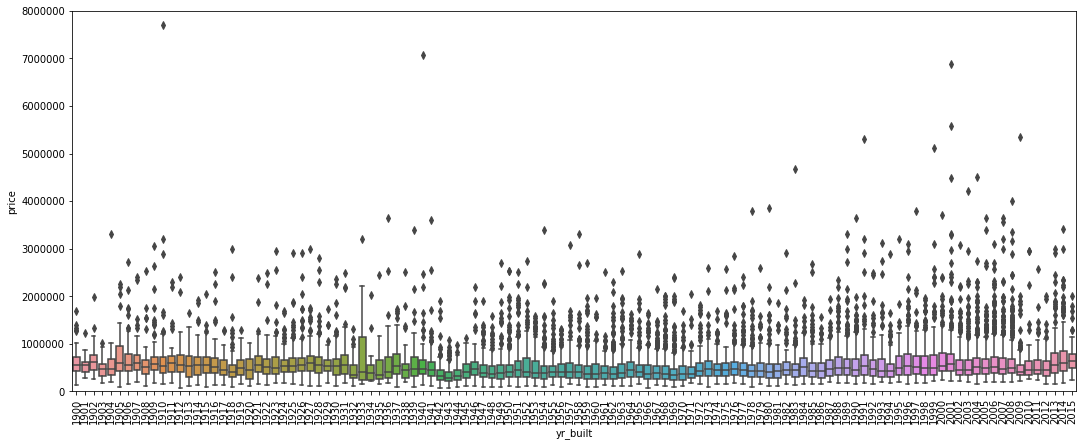

In [35]:
var = 'yr_built'
data = pd.concat([house['price'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 7))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);
plt.xticks(rotation=90);

### 4. Correlation Analysis

1. Correlation matrix - heatmap of all vs all
2. Multi-collinearity analysis
3. Correlation for n most correlated elements
4. Pairplot of those n significant elements


### 4.1 Correlation matrix - heatmap of all vs all


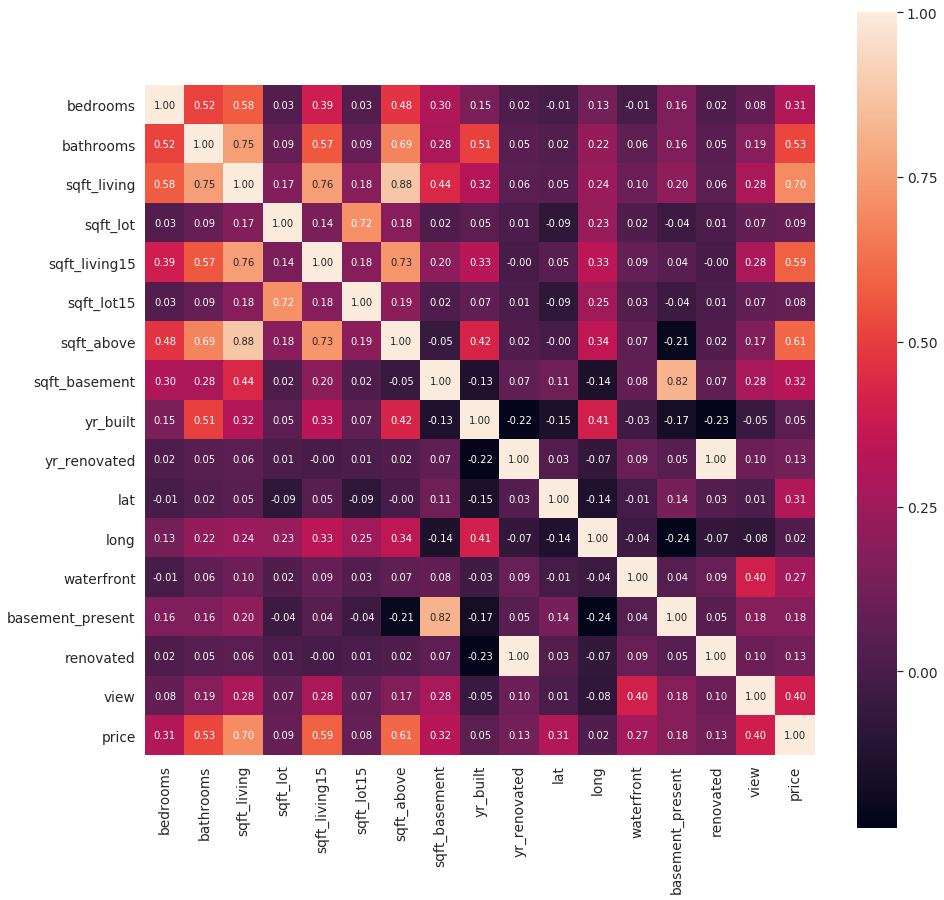

In [36]:
corr = house.corr()
cols = corr.index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 4.3 Multi-collinearity Analysis

Multi collinearity means those columns which display similar effects as others. From the above heatmap the variable lat, sqft_basement, waterfront have almost same probability values when it comes to the relation between the output variable price. Hence we can keep only once.

### 4.3 Correlation for n most correlated elements

We intend to find only the k most correlated features. Keeping threshold of 0.30 by doing a subjective analysis of above heatmap we observe that that 7 features contribute most to helping us predict output price. We then try to see what the algorithm returns and we get the 7 most correlated features from below and we plot its map

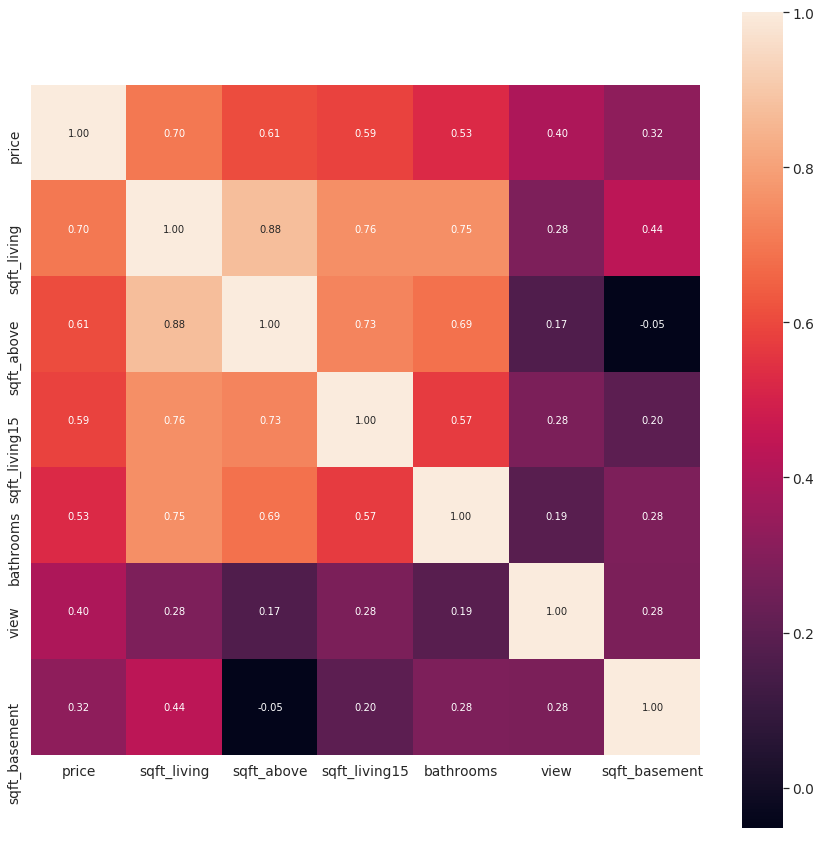

In [37]:
#saleprice correlation matrix
k = k #number of variables for heatmap
cols = corr.nlargest(k, 'price')['price'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 4.4 Pairplot of those n significant elements

We want to observe how these 7 features correlate and would like to visualize them. As can be seen from below they show an appreciable linear relation and can be used for now modelling our data

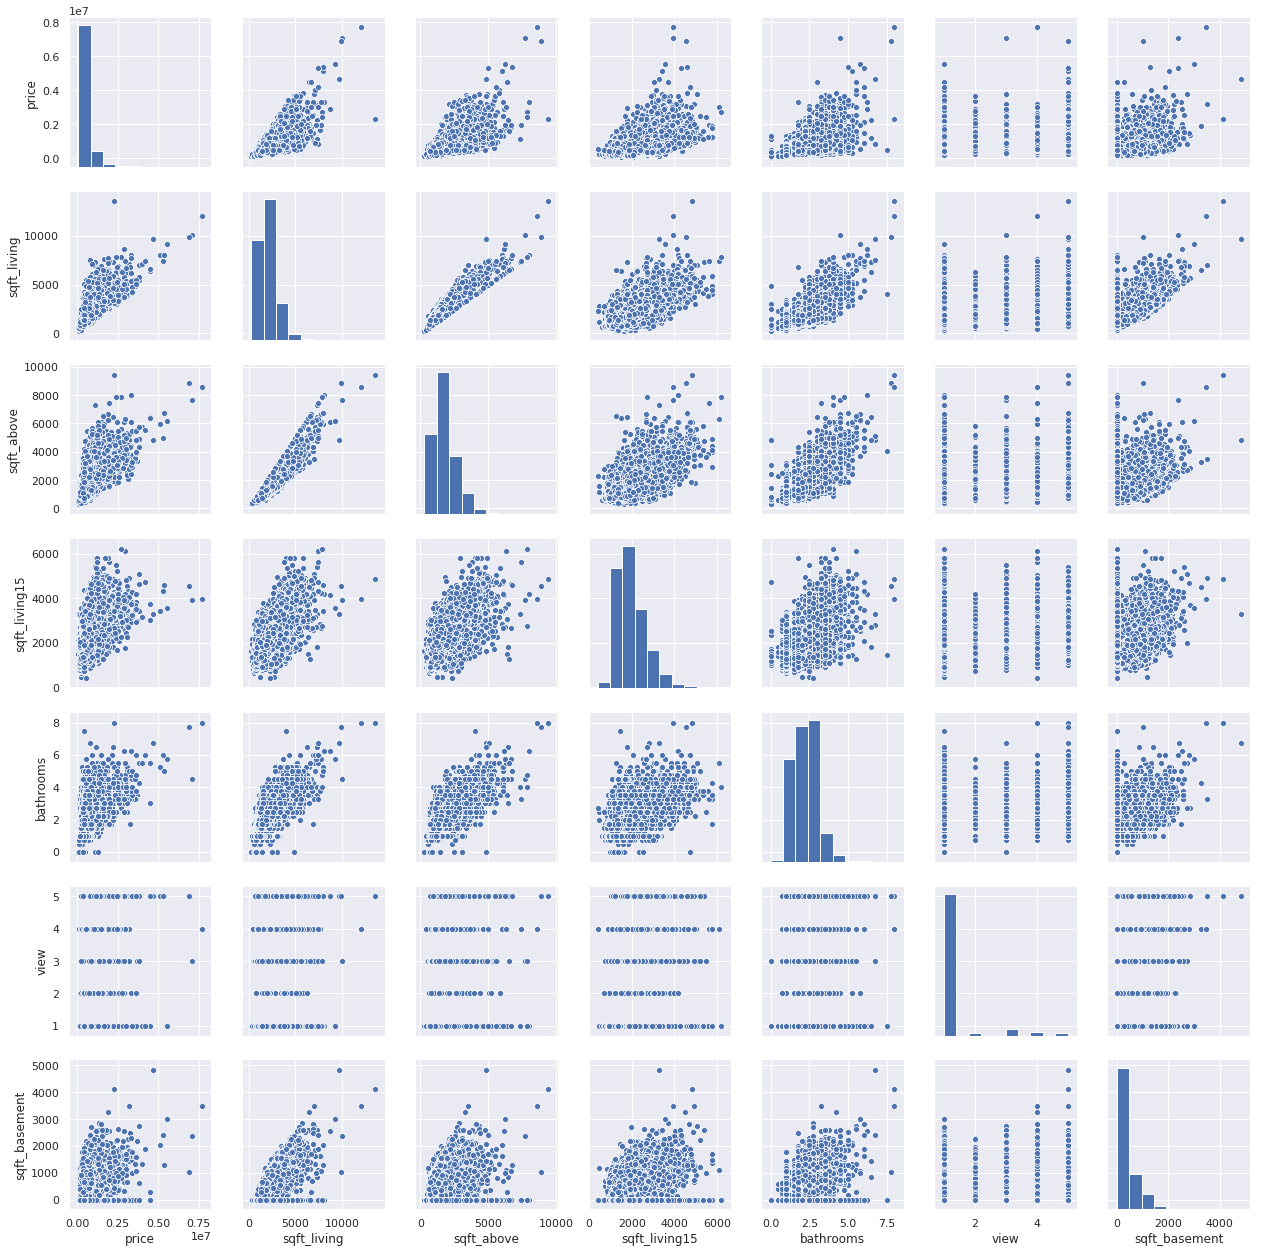

In [38]:
sns.set()
# cols = ['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront']
sns.pairplot(house[cols], height = 2.5)
plt.show();

### 5. Handling Missing Data

We want to account for missing data and hence we want to see what percentage of our data is missing from each column. Looks that we have no NaN values and our data is present fully.

In [39]:
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
price                 0      0.0
sqft_basement         0      0.0
bathrooms             0      0.0
sqft_living           0      0.0
sqft_lot              0      0.0
sqft_living15         0      0.0
sqft_lot15            0      0.0
sqft_above            0      0.0
yr_built              0      0.0
view                  0      0.0
yr_renovated          0      0.0
lat                   0      0.0
long                  0      0.0
waterfront            0      0.0
basement_present      0      0.0
renovated             0      0.0
bedrooms              0      0.0

### 6. Handling Outliers


In [40]:
saleprice_scaled = StandardScaler().fit_transform(house['price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.26686039]
 [-1.25868864]
 [-1.25324081]
 [-1.2505169 ]
 [-1.24779298]
 [-1.24643103]
 [-1.24506907]
 [-1.24234515]
 [-1.23962124]
 [-1.23962124]]

outer range (high) of the distribution:
[[10.75649871]
 [10.78646177]
 [11.24407943]
 [12.45022882]
 [12.96559346]
 [13.10178919]
 [13.70105041]
 [17.28299812]
 [17.76649297]
 [19.50298853]]


/home/nikunj/miniconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nikunj/miniconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The above analysis help us understand that we need to aware of data which lies in the outer range. Although not a necessary step, the above information helps us understand the range of outlier values present in our data.

### 7. Normality Testing - Homoscedasticity and Heteroscedasticity behaviour

Below plots don't have normal distirbution. What we are trying to do is understand its behaviour and compute data transformations by doing log transformations. This makes sure the homoscedastic behaviour is maintained and we get a normal distribution.

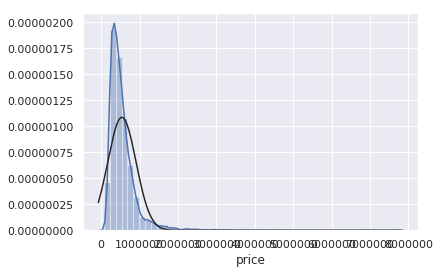

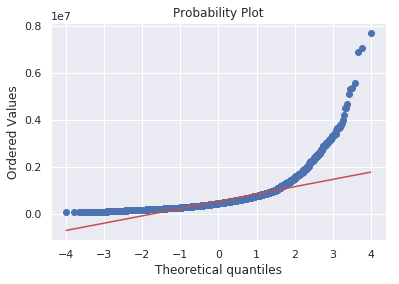

In [41]:
sns.distplot(house['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['price'], plot=plt)

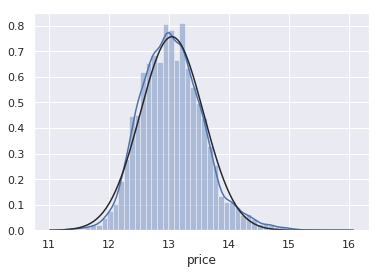

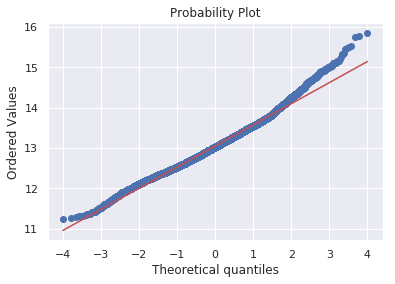

In [42]:
house['price'] = np.log(house['price'])

sns.distplot(house['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['price'], plot=plt)

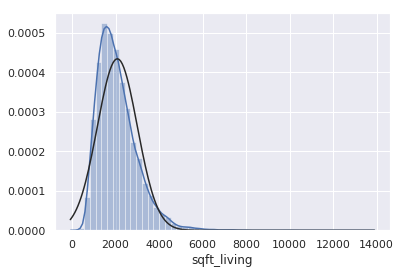

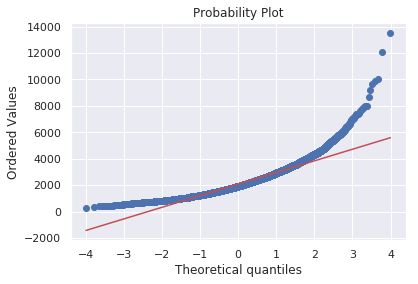

In [43]:
sns.distplot(house['sqft_living'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_living'], plot=plt)

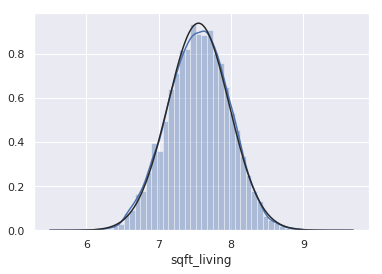

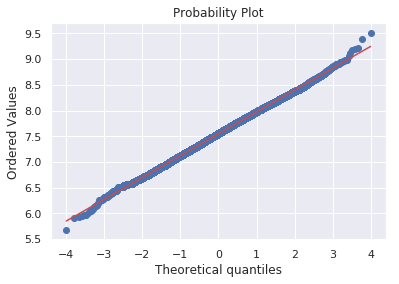

In [44]:
house['sqft_living'] = np.log(house['sqft_living'])

sns.distplot(house['sqft_living'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_living'], plot=plt)

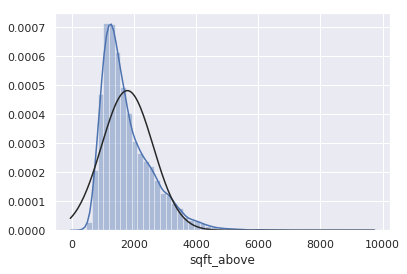

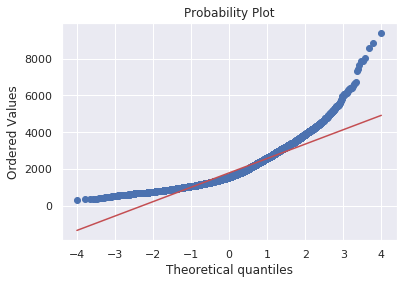

In [45]:
sns.distplot(house['sqft_above'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_above'], plot=plt)

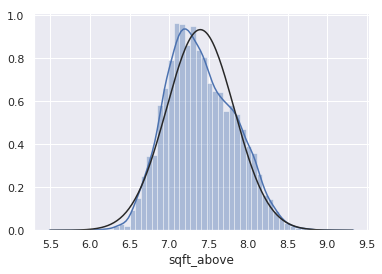

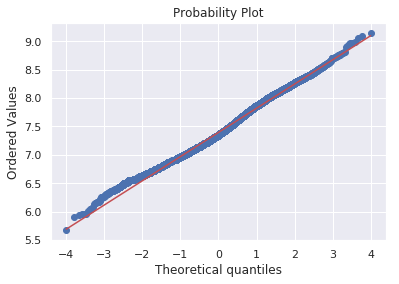

In [46]:
house['sqft_above'] = np.log(house['sqft_above'])

sns.distplot(house['sqft_above'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_above'], plot=plt)

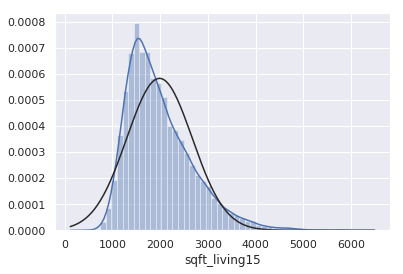

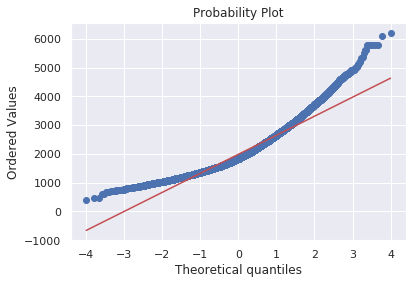

In [47]:
sns.distplot(house['sqft_living15'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_living15'], plot=plt)

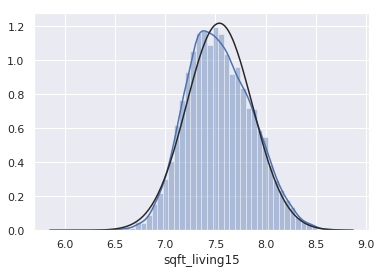

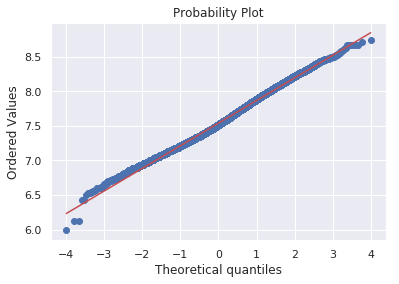

In [48]:
house['sqft_living15'] = np.log(house['sqft_living15'])

sns.distplot(house['sqft_living15'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_living15'], plot=plt)

The plots below show peakedness but multiple peaks. This will be harder to convert into normal behaviour. Hence we just visualize it and try to understand its nature. It does not Homoscedasticity.

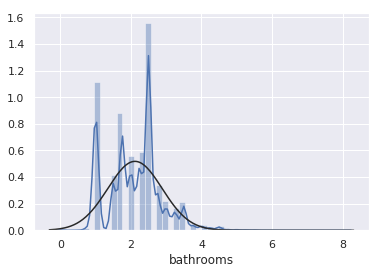

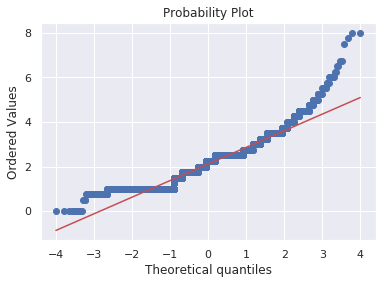

In [49]:
sns.distplot(house['bathrooms'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['bathrooms'], plot=plt)

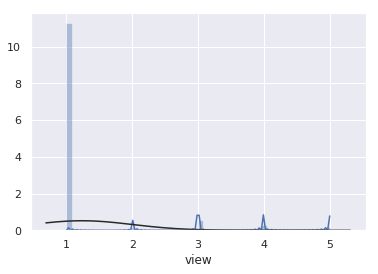

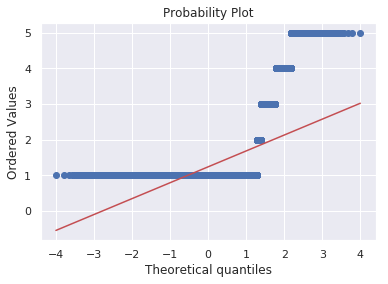

In [50]:
sns.distplot(house['view'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['view'], plot=plt)

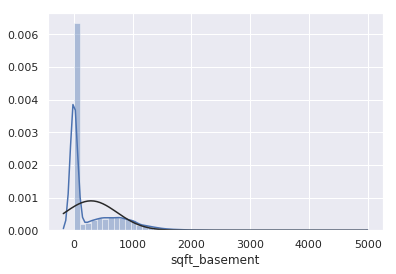

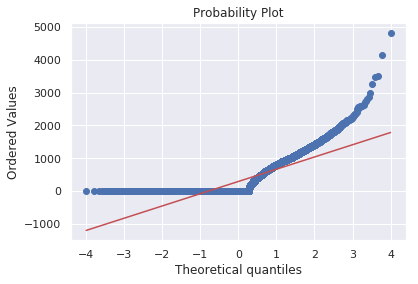

In [51]:
sns.distplot(house['sqft_basement'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['sqft_basement'], plot=plt)

We compute the median price so as to convert price to a binary valued column. 

In [52]:
median_price = house.loc[:,"price"].median()
print(median_price)

13.017002861746503


Here we try to create a new column which will hold the binary price data, i.e we make values above median as 1 and below median as 0

In [53]:
house['price_cat'] = house['price'].apply(lambda x: 1 if x > median_price else 0)
house[['price','price_cat']].head(10)

price  price_cat
0  12.988832          0
1  13.579788          1
2  13.422468          1
3  13.226723          1
4  12.994530          0
5  12.594731          0
6  13.060488          1
7  13.217674          1
8  12.653958          0
9  13.347106          1

In [54]:
house.head()

bedrooms  bathrooms  sqft_living  sqft_lot  sqft_living15  sqft_lot15  \
0         3       2.25     7.585789     35100       7.757906       35100   
1         3       2.50     7.863267      4750       7.774856        4750   
2         5       2.50     7.944492     67518       7.944492       48351   
3         4       2.50     8.104703      6500       7.774856        5000   
4         4       2.25     7.677864      8119       7.522941        9000   

   sqft_above  sqft_basement  yr_built  yr_renovated      lat     long  \
0    7.585789              0      1977             0  47.4635 -121.991   
1    7.438384            900      1951             0  47.6833 -122.400   
2    7.944492              0      1979             0  47.5794 -122.025   
3    8.104703              0      2012             0  47.5150 -121.870   
4    6.984716           1080      1966             0  47.5443 -122.177   

   waterfront  basement_present  renovated  view      price  price_cat  
0           0                 0          0   1.0  12.988832          0  
1           0                 1          0   1.0  13.579788          1  
2           0                 0          0   1.0  13.422468          1  
3           0                 0          0   1.0  13.226723          1  
4           0                 1          0   1.0  12.994530          0

## Regression Analysis

### Random Forest based Regression


In [55]:
# first we generate a random forest regressor with default settings. 
rf = RandomForestRegressor(random_state = 42)

# We obeserve the parameters which are currently in use.
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Above is the list of hyperparameters present which can be tuned by Random Forest Regressor.

In [56]:
columns = list(house)
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_living15',
 'sqft_lot15',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'waterfront',
 'basement_present',
 'renovated',
 'view',
 'price',
 'price_cat']

In [57]:
Xit = house[columns[0:16]]
Xit.head()

bedrooms  bathrooms  sqft_living  sqft_lot  sqft_living15  sqft_lot15  \
0         3       2.25     7.585789     35100       7.757906       35100   
1         3       2.50     7.863267      4750       7.774856        4750   
2         5       2.50     7.944492     67518       7.944492       48351   
3         4       2.50     8.104703      6500       7.774856        5000   
4         4       2.25     7.677864      8119       7.522941        9000   

   sqft_above  sqft_basement  yr_built  yr_renovated      lat     long  \
0    7.585789              0      1977             0  47.4635 -121.991   
1    7.438384            900      1951             0  47.6833 -122.400   
2    7.944492              0      1979             0  47.5794 -122.025   
3    8.104703              0      2012             0  47.5150 -121.870   
4    6.984716           1080      1966             0  47.5443 -122.177   

   waterfront  basement_present  renovated  view  
0           0                 0          0   1.0  
1           0                 1          0   1.0  
2           0                 0          0   1.0  
3           0                 0          0   1.0  
4           0                 1          0   1.0

In [58]:
yit = house[columns[-2]]
yit.head()  # using continous valued target variable

0    12.988832
1    13.579788
2    13.422468
3    13.226723
4    12.994530
Name: price, dtype: float64

In [59]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(Xit, yit, test_size=0.3) # 70% training and 30% test

The below function is used for evaluating our model which will be trained by the algorithms to follow. We get the model accuracy and average error

In [60]:
def evaluate_reg(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

### Grid Search Cross Validation

We 

In [61]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [200, 300, 350]
}

rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [62]:
# Fit the grid search to the data
grid_search_rf.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
/home/nikunj/miniconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/nikunj/miniconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/nikunj/miniconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while 

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'max_depth': [None], 'max_features': [2, 3], 'min_samples_leaf': [2, 3, 4], 'min_samples_split': [3, 5, 7], 'n_estimators': [200, 300, 350]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

**Best Hyperparameter values**

In [63]:
grid_search_rf.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 350}

In [64]:
base_accuracy = evaluate_reg(grid_search_rf, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.1374 degrees.
Accuracy = 98.94%.


### XGBoost based Regression

In [65]:
base_model = XGBRegressor()
base_model.fit(X_train_reg, y_train_reg)
base_accuracy = evaluate_reg(base_model, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.1446 degrees.
Accuracy = 98.89%.


In [66]:
base_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [67]:
model = XGBRegressor()

# Hyperparameters
n_estimators = [300,350,400]
max_depth = [4,5,6,7]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
grid_search_xgbr = GridSearchCV(model, param_grid, n_jobs=-1, cv=3, verbose=1)
grid_result_xgbr = grid_search_xgbr.fit(X_train_reg, y_train_reg)
# summarize results
print("Best: %f using %s" % (grid_result_xgbr.best_score_, grid_result_xgbr.best_params_))
means = grid_result_xgbr.cv_results_['mean_test_score']
stds = grid_result_xgbr.cv_results_['std_test_score']
params = grid_result_xgbr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.1min finished


Best: 0.885611 using {'max_depth': 6, 'n_estimators': 300}
0.882707 (0.002443) with: {'max_depth': 4, 'n_estimators': 300}
0.883305 (0.002488) with: {'max_depth': 4, 'n_estimators': 350}
0.883698 (0.002438) with: {'max_depth': 4, 'n_estimators': 400}
0.884357 (0.004003) with: {'max_depth': 5, 'n_estimators': 300}
0.884500 (0.003926) with: {'max_depth': 5, 'n_estimators': 350}
0.884353 (0.003960) with: {'max_depth': 5, 'n_estimators': 400}
0.885611 (0.004052) with: {'max_depth': 6, 'n_estimators': 300}
0.885474 (0.003807) with: {'max_depth': 6, 'n_estimators': 350}
0.885114 (0.003872) with: {'max_depth': 6, 'n_estimators': 400}
0.885415 (0.003750) with: {'max_depth': 7, 'n_estimators': 300}
0.884735 (0.003715) with: {'max_depth': 7, 'n_estimators': 350}
0.884400 (0.003743) with: {'max_depth': 7, 'n_estimators': 400}


**Best Hyperparameters**

In [68]:
best_XGBRegressor = grid_result_xgbr.best_estimator_
best_XGBRegressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
base_accuracy = evaluate_reg(best_XGBRegressor, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.1257 degrees.
Accuracy = 99.03%.


### Linear Regression


In [70]:
lr = LinearRegression()
grid_params_lr = [{'fit_intercept' : [True,False],
                  'normalize' :[True,False],
                  'n_jobs' :[-1,1] }]
grid_search_lr = GridSearchCV(lr, grid_params_lr, n_jobs=-1, cv=3, verbose=1)
grid_result_lr = grid_search_lr.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished


**Best Hyperparameters**

In [71]:
best_LR = grid_result_lr.best_estimator_
best_LR

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [72]:
best_LR.fit(X_train_reg, y_train_reg)
best_accuracy = evaluate_reg(best_LR, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.2156 degrees.
Accuracy = 98.35%.


### Ridge Regression - L2 Regularization


In [73]:
rr = Ridge()
rr.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [74]:
alpha=[i for i in np.arange(0,1,0.2)]
fit_intercept=[True, False], 
normalize=[True, False], 
precompute=[True, False],  
max_iter=[i for i in range(0,500,20)] 

grid_params_rr = [{'fit_intercept' : fit_intercept, 'normalize' :normalize, 'max_iter': max_iter, 'alpha': alpha }] 
grid_search_rr = GridSearchCV(rr, grid_params_rr, n_jobs=-1, cv=3, verbose=1)
grid_result_rr = grid_search_rr.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 368 out of 375 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    1.7s finished


**Best Hyperparameters**

In [75]:
best_RR = grid_result_rr.best_estimator_
best_RR

Ridge(alpha=0.0, copy_X=True, fit_intercept=[True, False], max_iter=0,
   normalize=[True, False], random_state=None, solver='auto', tol=0.001)

In [76]:
best_RR.fit(X_train_reg, y_train_reg)
best_accuracy = evaluate_reg(best_RR, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.2156 degrees.
Accuracy = 98.35%.


From the above Regression analysis we observe

|         Algorithm       |    Accuracy    |
|-------------------------|----------------|
| Random Forest Regressor |    98.94%      |
| XGBoost Regressor       |    99.03%      |
| Linear Regression       |    98.35%      |
| Ridge Regression - L2   |    98.35%      |

From above we conclude that XGBoost performs best with the best set of hyper parameters

## Classification Analysis


In [77]:
yd = house[columns[-1]]
yd.head()

0    0
1    1
2    1
3    1
4    0
Name: price_cat, dtype: int64

In [78]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(Xit, yd, test_size=0.3) # 70% training and 30% test

In [79]:
def evaluate(model, X_train,y_train, X_test, y_test):
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #print(roc)
    return roc_auc

### Random Forest Based Classification

In [80]:
rfc = RandomForestClassifier(random_state = 50)
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}

In [81]:
bootstrap = [True, False]
criterion = ['gini', 'entropy']
max_features =  ['sqrt', 'log2']
min_samples_leaf =  [2, 3]
min_samples_split =  [3, 5]
n_estimators = [200, 250, 300]

grid_params_rfc = [{'criterion': criterion, 'max_features': max_features, 
                    'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split,
                    'n_estimators': n_estimators}] 
grid_search_rfc = GridSearchCV(rfc, grid_params_rfc, n_jobs=-1, cv=3, verbose=1)
grid_result_rfc = grid_search_rfc.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.6min finished


**Best Hyperparameters**

In [82]:
best_RFC = grid_result_rfc.best_estimator_
best_RFC

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [83]:
best_RFC.fit(X_train_reg, y_train_reg)
auc = evaluate(best_RFC, X_train_reg, y_train_reg, X_test_reg, y_test_reg)
auc

0.9111874455750623

### XGBoost based Classification


In [84]:
xgbc = XGBClassifier()
n_estimators = [350, 300, 250, 400]
max_depth = [6, 7, 8, 9]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
grid_search_xgbc = GridSearchCV(xgbc, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=3, verbose=1)
grid_result_xgbc = grid_search_xgbc.fit(X_train_reg, y_train_reg)
# summarize results
print("Best: %f using %s" % (grid_result_xgbc.best_score_, grid_result_xgbc.best_params_))
means = grid_result_xgbc.cv_results_['mean_test_score']
stds = grid_result_xgbc.cv_results_['std_test_score']
params = grid_result_xgbc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

[6, 7, 8, 9]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


Best: -0.233002 using {'max_depth': 6, 'n_estimators': 250}
-0.238587 (0.010616) with: {'max_depth': 6, 'n_estimators': 350}
-0.235807 (0.009752) with: {'max_depth': 6, 'n_estimators': 300}
-0.233002 (0.008963) with: {'max_depth': 6, 'n_estimators': 250}
-0.242075 (0.011339) with: {'max_depth': 6, 'n_estimators': 400}
-0.244796 (0.012230) with: {'max_depth': 7, 'n_estimators': 350}
-0.239885 (0.011564) with: {'max_depth': 7, 'n_estimators': 300}
-0.234996 (0.010310) with: {'max_depth': 7, 'n_estimators': 250}
-0.249543 (0.013455) with: {'max_depth': 7, 'n_estimators': 400}
-0.254461 (0.011561) with: {'max_depth': 8, 'n_estimators': 350}
-0.248612 (0.011424) with: {'max_depth': 8, 'n_estimators': 300}
-0.242862 (0.010921) with: {'max_depth': 8, 'n_estimators': 250}
-0.260077 (0.012350) with: {'max_depth': 8, 'n_estimators': 400}
-0.268490 (0.014739) with: {'max_depth': 9, 'n_estimators': 350}
-0.261621 (0.013822) with: {'max_depth': 9, 'n_estimators': 300}
-0.254720 (0.012692) with: {'m

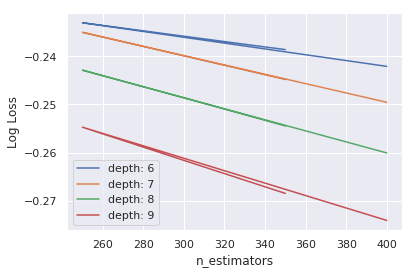

In [85]:
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth.png')

In [86]:
best_XGBClassifier = grid_result_xgbr.best_estimator_
best_XGBClassifier

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [111]:
auc = evaluate(best_XGBClassifier, X_train_reg, y_train_reg, X_test_reg, y_test_reg)
auc

TypeError: 'numpy.float64' object is not callable

### Logistic Regression


In [89]:
logreg=LogisticRegression().fit(X_train_reg,y_train_reg)
logreg
print("Training set score: {:.3f}".format(logreg.score(X_train_reg,y_train_reg)))
print("Test set score: {:.3f}".format(logreg.score(X_test_reg,y_test_reg)))

Training set score: 0.742
Test set score: 0.749


In [90]:
logit_model=sm.Logit(y_train_reg,X_train_reg)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.396552
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              price_cat   No. Observations:                15129
Model:                          Logit   Df Residuals:                    15113
Method:                           MLE   Df Model:                           15
Date:                Wed, 30 Jan 2019   Pseudo R-squ.:                  0.4279
Time:                        23:39:13   Log-Likelihood:                -5999.4
converged:                       True   LL-Null:                       -10486.
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
bedrooms            -0.3771      0.034    -11.056      0.000      -0.444      -0.310
bathrooms  

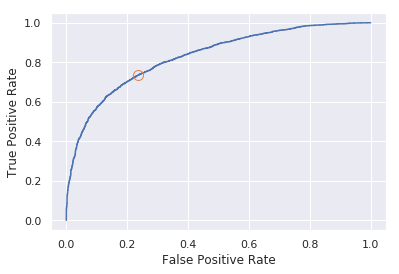

In [91]:
falsepos,truepos,thresholds=roc_curve(y_test_reg,logreg.decision_function(X_test_reg))

plt.plot(falsepos,truepos,label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

cutoff=np.argmin(np.abs(thresholds))
plt.plot(falsepos[cutoff],truepos[cutoff],'o',markersize=10,label="cutoff",fillstyle="none")
plt.show()

In [92]:
from sklearn import metrics
metrics.auc(falsepos, truepos)

0.8293965168801039

### Gradient Boosting Algorithm


In [94]:
gb = GradientBoostingRegressor()
gb.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [95]:
gb.score(X_test_reg, y_test_reg)

0.6976803812668766

In [104]:
param_grid = {'n_estimators': [100,150], 'learning_rate': [0.25, 0.35], 'min_samples_leaf': [3,5], 'max_features': [0.5, 0.3, 1.0]}
reg = GridSearchCV(estimator=gb, cv=3, param_grid = param_grid, n_jobs = -1, verbose = 1)
reg.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   23.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150], 'learning_rate': [0.25, 0.35], 'min_samples_leaf': [3, 5], 'max_features': [0.5, 0.3, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [107]:
reg.best_estimator_
reg_tuned =  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
reg_tuned.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [108]:
evaluate_reg(reg_tuned, X_test_reg, y_test_reg)

Model Performance
Average Error: 0.1859 degrees.
Accuracy = -inf%.


-inf

## Conclusions


We conclude that Random Forest Classifier is the best in terms of accuracy. Although different hyper parameters were tuned the gradient boosting threw -inf while XGBoost showed float error. 

## Contributions


The entire notebook was created from scratch with just about 30% code taken from original source.
Entire EDA done on my own. All the evaluations and algorithms

## Citations

1. [Exploratory Data Analysis Guide](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
2. [Grid Search Concepts](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
3. [Scikit Learn](https://scikit-learn.org/stable/)
4. [Understanding Box Plots](https://www.wellbeingatschool.org.nz/information-sheet/understanding-and-interpreting-box-plots)
5. [Pandas zero value calculation](https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical/29803297)

## License

Copyright 2019 Nikunj Lad

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.